# Natural Earth for CMAQ/CAMx

    author: Barron H. Henderson
    date: 2021-03-26

Requires:
  * Python or Google Colab or Amazon Web Service or Binder...
  * Natural Earth Admin 0 shapefile (https://www.naturalearthdata.com/)
    * Download ne_10m_admin_0_countries.zip
    * Make a folder called shapefiles and unzip ne_10m_admin_0_countries.zip to that folder
    * So, shapefiles/ne_10m_admin_0_countries.shp will exists relative to this folder

In [1]:
%%bash
cd shapefiles/
unzip -o ../downloads/ne_10m_admin_0_countries.zip


Archive:  ../downloads/ne_10m_admin_0_countries.zip
  inflating: ne_10m_admin_0_countries.README.html  
 extracting: ne_10m_admin_0_countries.VERSION.txt  
 extracting: ne_10m_admin_0_countries.cpg  
  inflating: ne_10m_admin_0_countries.dbf  
  inflating: ne_10m_admin_0_countries.prj  
  inflating: ne_10m_admin_0_countries.shp  
  inflating: ne_10m_admin_0_countries.shx  


In [2]:
installprereqs = False
if installprereqs:
    !pip install shapely pyproj pyshp pseudonetcdf pycno

# Import Libraries

* `numpy` for numeric arrays
* `shapely` for spatial processing
* `matplotlib` for plotting
* `PseudoNetCDF` for IOAPI-like output

In [178]:
import os
import numpy as np
import datetime

from shapely.geometry import LineString, Polygon, shape, asPolygon, asLineString, GeometryCollection, Point
from shapely.strtree import STRtree
from shapely.ops import substring, cascaded_union, transform
import shapefile
import matplotlib.pyplot as plt
import pandas as pd

import PseudoNetCDF as pnc
import pycno
import pyproj

In [179]:
crs_4326 = pyproj.CRS.from_epsg(4326)
crs_4326.name

'WGS 84'

# Select Natural Earth Layer and CMAQ Domain

In [200]:
GDNAM = '12US1'
#shapepath = 'shapefiles/ne_10m_admin_0_countries.shp'
shapepath = 'shapefiles/ne_10m_time_zones.shp'
#shapepath = 'shapefiles/ne_50m_admin_1_states_provinces.shp'

# In natural earth, some country codes are not included. This is described in
# several issues, which are all linked to 284. For my purposes, the "EH" version
# described in 268 as "okay, but not great" solves the problem...
#
# https://github.com/nvkelso/natural-earth-vector/issues/284
# https://github.com/nvkelso/natural-earth-vector/issues/268
if 'admin_0' in shapepath:
    badval = '-99'
    propkey = 'ADM0_A3'
    #propkey = 'REGION_UN'
    #propkey = 'SUBREGION'
    #propkey = 'REGION_WB'
    #propkey = 'CONTINENT'
    #propkey = 'ECONOMY'
    #propkey = 'INCOME_GRP'
elif 'admin_1' in shapepath:
    badval = ''
    propkey = 'iso_3166_2'
elif 'time_zones' in shapepath:
    badval = ''
    propkey = 'name'
else:
    badval = ''
    propkey = 'unknown'
outpath = os.path.join('output', os.path.basename(shapepath).replace('.shp', '') + f'.{propkey}.{GDNAM}.nc')
outpath

'output/ne_10m_time_zones.name.12US1.nc'

# Prepare grid Cell Polygons

* Open GRIDDESC for grid of interest
* Get projection object with grid units (cell area is 1x1 in units of XCELL)
* Convert each cell to a polygon
* Create a tree for fast spatial subsetting

In [201]:
gf = pnc.pncopen('/home/bhenders/GRIDDESC', format='griddesc', GDNAM=GDNAM)
gridproj = gf.getproj(withgrid=True)
ll2xy = pyproj.Transformer.from_proj(crs_4326, gridproj, always_xy=True).transform
ll2xy = lambda x, y: gridproj(x, y, inverse=False)
cno = pycno.cno(proj=gridproj)

In [202]:
# First create a series of polygons representing each grid cell
# Then, create a tree for fast subsetting based on the ocean
# segment.
def cell(i, j):
  return Polygon(
      [
        [i + 0, j + 0],
        [i + 1, j + 0],
        [i + 1, j + 1],
        [i + 0, j + 1],
        [i + 0, j + 0],
      ]
  )

gridpolys = np.array([[cell(i, j) for i in range(gf.NCOLS)] for j in range(gf.NROWS)], dtype='object')
gcelltree = STRtree(gridpolys.ravel())

In [203]:
if gf.GDTYP == 6:
    # Polar stereographic domains that cross the north pole are not
    # well defined without complex regridding. To avoid this, we simply
    # force the clipping to include from 30S to 90N
    wholedomain_lonlat = asPolygon([(-180, -30), (180, -30), (180, 90), (-180, 90), (-180, -30)])
else:
    wholedomain = cascaded_union(gridpolys.ravel())
    wholedomain_lonlat = asPolygon(np.array(gridproj(*np.array(wholedomain.exterior.coords).T, inverse=True)).T)


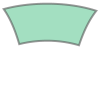

In [204]:
wholedomain_lonlat

# Read and Prepare Country Shapes

* Use pyshp reader (`shapefile.Reader`) to open shpaefile
* Review attribute fields and choose a field for country names (e.g., ISO_A3)
* Create shapes with property (`propkey`) based on fields
* Find intersections of polygons with domain in latlon (keep property)
* Create country polygons in LCC space (keep property)

In [205]:
shpf = shapefile.Reader(shapepath)

In [206]:
flddefs = [(fi - 1, flddef) for fi, flddef in enumerate(shpf.fields) if fi != 0]
fldnames = [flddef[0] for fi, flddef in flddefs]
if propkey not in fldnames:
    print(f'***** Choose another propkey; {propkey} not in fldnames.')
    print(flddefs)


In [207]:
shapes = []
badrecords = []
for sr in shpf.iterShapeRecords():
    cshp = shape(sr.shape)
    setattr(cshp, 'record', dict(zip(fldnames, sr.record)))
    if badval == cshp.record[propkey]:
        badrecords.append(cshp.record)
    shapes.append(cshp)

print(len(shapes), 'shapefile shapes')
if len(badrecords) > 0:
    print('Review bad codes')
    pd.DataFrame.from_records(badrecords)
    print('Review bad codes')
    

120 shapefile shapes


In [208]:
shapes_intx = []
for shapei in shapes:
    if shapei.intersects(wholedomain_lonlat):
        cshp = shapei.intersection(wholedomain_lonlat)
        setattr(cshp, 'record', getattr(shapei, 'record'))
        shapes_intx.append(cshp)
print(len(shapes_intx), 'shapes')

8 shapes


In [209]:
shapes_polys_lcc = []
for shapei in shapes_intx:
    # Polygons are geometries, but there are also
    # MultiPologons, which have geometries
    if shapei.type == 'Polygon':
        geoms = [shapei]
    else:
        geoms = shapei.geoms
    for geom in geoms:
        # Points and Lines should not be processed
        if geom.type in ('MultiPolygon', 'Polygon'):
            # cshp = asPolygon(np.array(proj(*np.asarray(geom.exterior.coords).T)).T)
            cshp = transform(ll2xy, geom)
            setattr(cshp, 'record', getattr(shapei, 'record'))
            shapes_polys_lcc.append(cshp)
print(len(shapes_polys_lcc), 'polygons')

10 polygons


# Calculate Fractional Area Overlap by Shape

In [210]:
template = np.zeros((gf.NROWS, gf.NCOLS), dtype='f')
propareas = {}
proprecords = {}
nl = len(shapes_polys_lcc)
print('Some polygons have many grid cells, others few.')
print('So, the OVERALL progress meter can be misleading (slow or fast)')
print('OVERALL POLYGON')
for li, shapes_poly_lcc in enumerate(shapes_polys_lcc):
    propval = shapes_poly_lcc.record[propkey]
        
    propareas.setdefault(propval, template.copy())
    proprecords.setdefault(propval, shapes_poly_lcc.record)
    proparea = propareas[propval]
    gcells = gcelltree.query(shapes_poly_lcc)
    ng = len(gcells)
    for gi, gcell in enumerate(gcells):
        print(f'\r {(li)/nl:6.1%} {(gi)/ng:6.1%}', end='')
        j = int(gcell.exterior.coords[0][1])
        i = int(gcell.exterior.coords[0][0])
        if shapes_poly_lcc.contains(gcell):
            intxarea = 1
        else:
            intxarea = shapes_poly_lcc.intersection(gcell).area
        proparea[j, i] += intxarea
    
print('\r 100.0% 100.0%')

Some polygons have many grid cells, others few.
So, the OVERALL progress meter can be misleading (slow or fast)
OVERALL POLYGON
 100.0% 100.0%


In [211]:
propkey, len(propareas), sorted(propareas)

('name', 8, ['-3', '-3.5', '-4', '-5', '-6', '-7', '-8', '-9'])

In [212]:
explicit2key = {
    badval: 'UNKNOWN',
    'Australia and New Zealand': 'AUSNZL', # REGION_UN, REGION_WB, SUBREGIONS
    'Northern America': 'North_America',
    'South-Eastern Asia': 'SE_Asia',
    'East Asia & Pacific': 'EastAsia_PAC',
    'Europe & CentralAsia': 'EUR_CentralAsia',
    'Latin America & Caribbean': 'LAC',
    'Middle East & North Africa': 'MDE_NAF',
    'Sub-Saharan Africa': 'SubSahara',
    'Seven seas (open ocean)': 'SevenSeas',
    '0': 'PLUS0', # time zone
    '1. Developed region: G7': 'DEVELOPED_G7', # ECONOMY
    '2. Developed region: nonG7': 'DEVELOPED_nonG7',
    '3. Emerging region: BRIC': 'EMERGING_BRIC',
    '4. Emerging region: MIKT': 'EMERGING_MIKT',
    '5. Emerging region: G20': 'EMERGING_G20',
    '6. Developing region': 'DEVELOPING',
    '7. Least developed region': 'LEAST_DEVELOPED',
    '1. High income: OECD': 'HIGH_OECD',
    '2. High income: nonOECD': 'HIGH_nonOECD',
    '3. Upper middle income': 'UPPER_MID',
    '4. Lower middle income': 'LOWER_MID',
    '5. Low income': 'LOW',
    # INCOME_GRP
}

In [213]:
def namecleaner(origkey, shapepath):
    if origkey in explicit2key:
        return explicit2key[origkey]
    
    key = origkey
    # For REGION_WB REGION_UN SUBREGIONS
    key = key.replace(' ', '').replace('&', '_')
    key = key.replace('.', '_').replace('/', '_').replace('&', '_')
    if 'time_zone' in shapepath:
        key = key.replace('+', 'PLUS').replace('-', 'MINUS')
    else:
        key = key.replace('-', '')
    return key

In [214]:
inname2outname = {
    k: namecleaner(k, shapepath)
    for k in set([shapei.record[propkey] for shapei in shapes_intx])
}
for key, outname in inname2outname.items():
    namelength = len(outname)
    if namelength > 15:
        print(f'{key} = {outname} <--- too long  ({namelength})')
    else:
        print(f'{key} = {outname}  ({namelength})')
    

-3 = MINUS3  (6)
-7 = MINUS7  (6)
-9 = MINUS9  (6)
-8 = MINUS8  (6)
-5 = MINUS5  (6)
-6 = MINUS6  (6)
-4 = MINUS4  (6)
-3.5 = MINUS3_5  (8)


In [215]:
outf = gf.subset(['TFLAG'])
for key, vals in propareas.items():
    myrecord = proprecords[key]
    outkey = inname2outname[key]
    outv = outf.createVariable(outkey, 'f', ('TSTEP', 'LAY', 'ROW', 'COL'))
    # Copy to avoid modifying original
    props = {k: v for k, v in myrecord.items()}
    for namekey in ['NAME', 'name']:
        if namekey in props:
            props['var_desc'] = props.pop(namekey).ljust(80)[:80]
            props['long_name'] = props['var_desc'][:16]
            break
    else:
        props['long_name'] = outkey.ljust(16)
        props['var_desk'] = key.ljust(16)
    outv.setncatts(props)
    outv.units = '1'
    outv[:] = vals


In [216]:
outf.FILEDESC = f"""{shapepath} {propkey}"""
datestr = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S%z')
outf.HISTORY = f"Created by NaturalEarth_for_CMAQ.ipynb at {datestr}"

In [217]:
outpath

'output/ne_10m_time_zones.name.12US1.nc'

In [218]:
if os.path.exists(outpath):
    os.remove(outpath)

outf.save(outpath, format='NETCDF4_CLASSIC', complevel=1, verbose=0).close()